# Глубокое обучение. Лабораторная работа №2

**Цель:** разработать и обучить сверточную нейронную сеть для задачи классификации изображений с использованием  PyTorch. 

**Требования к результатам выполнения работы:**

1. Требования к структуре и содержимому Jupyter Notebook:
    - Загрузить и проверить данные (необходимо обеспечить демонстрацию избранных изображений и меток классов для подтверждения корректности загрузки и совпадения размерностей).
    - Реализовать архитектуру нейронной сеть с использованием фреймворка PyTorch.
    - Настроить гиперпараметры обучения (например, архитектуры, скорости обучения и размера пачки (batch size)).
    - Вывести ошибку классификации и точность на тренировочном наборе данных по окончании каждой эпохи.
    - Вывести ошибку классификации на тестовом наборе данных и построить график ошибки обучения после обучения.

2. Выбор архитектуры:
    - Необходимо использовать ***сверточные*** архитектуры нейронных сетей
    - Разрешается использовать как готовые архитектуры (например, VGG, ResNet и тд), так и архитектуры разработанные студентом самостоятельно. 
    - Реализация должна быть выполнена с нуля в PyTorch, без использования готовых модулей (например, import Resnet недопустимо).

In [1]:
from datetime import datetime
import os
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import torchinfo
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
from time import time
%matplotlib inline

In [2]:
# Гиперпараметры
RANDOM_SEED = 5924
BATCH_SIZE = 256
LEARNING_RATE = 0.1
LEARNING_RATE_MIN = 0.0001
SCHEDULING_FACTOR = 0.8
SCHEDULING_PATIENCE = 3
NUM_EPOCHS = 30

## Подготовка данных

В качестве входных данных используется датасет Cifar-10 с сайта https://www.cs.toronto.edu/~kriz/cifar.html

### Загрузка и нормализация данных

Для создания загрузчика были использованы обучающие материалы с сайта https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
torch.manual_seed(RANDOM_SEED)
print("Using random seed", RANDOM_SEED)
train_dataset = datasets.CIFAR10(root="/work/cifar", train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root="/work/cifar", train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print("Train datset size:", len(train_dataset))
print("Test datset size:", len(test_dataset))

Using random seed 5924
Files already downloaded and verified
Files already downloaded and verified
Train datset size: 50000
Test datset size: 10000


### Визуальная верификация

Визуализация случайных изображений и вывод названий классов для первых восьми.

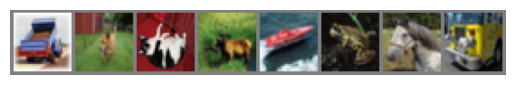

truck   dog   cat  deer  ship  frog horse truck


In [4]:
def imshow(img):
    img = (img / 2 + 0.5).numpy() # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.axis("off")
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[:8]))
print(' '.join("%5s" % classes[labels[j]] for j in range(8)))

## Нейронная сеть MobileNet

> Howard A.G., et al. MobileNets: Efficient Convolutional Neural Networks for Mobile Vision Applications (2017) https://arxiv.org/pdf/1704.04861.pdf

### Последовательность слоёв

| Type / Stride | Filter Shape        | Input Size     |
|---------------|---------------------|----------------|
| Conv / s2     | 3 × 3 × 3 × 32      | 224 × 224 × 3  |
| Conv dw / s1  | 3 × 3 × 32 dw       | 112 × 112 × 32 |
| Conv / s1     | 1 × 1 × 32 × 64     | 112 × 112 × 32 |
| Conv dw / s2  | 3 × 3 × 64 dw       | 112 × 112 × 64 |
| Conv / s1     | 1 × 1 × 64 × 128    | 56 × 56 × 64   |
| Conv dw / s1  | 3 × 3 × 128 dw      | 56 × 56 × 128  |
| Conv / s1     | 1 × 1 × 128 × 128   | 56 × 56 × 128  |
| Conv dw / s2  | 3 × 3 × 128 dw      | 56 × 56 × 128  |
| Conv / s1     | 1 × 1 × 128 × 256   | 28 × 28 × 128  |
| Conv dw / s1  | 3 × 3 × 256 dw      | 28 × 28 × 256  |
| Conv / s1     | 1 × 1 × 256 × 256   | 28 × 28 × 256  |
| Conv dw / s2  | 3 × 3 × 256 dw      | 28 × 28 × 256  |
| Conv / s1     | 1 × 1 × 256 × 512   | 14 × 14 × 256  |
| 5× {          |                     |                |
| Conv dw / s1  | 3 × 3 × 512 dw      | 14 × 14 × 512  |
| Conv / s1     | 1 × 1 × 512 × 512   | 14 × 14 × 512  |
| }             |                     |                |
| Conv dw / s2  | 3 × 3 × 512 dw      | 14 × 14 × 512  |
| Conv / s1     | 1 × 1 × 512 × 1024  | 7 × 7 × 512    |
| Conv dw / s2  | 3 × 3 × 1024 dw     | 7 × 7 × 1024   |
| Conv / s1     | 1 × 1 × 1024 × 1024 | 7 × 7 × 1024   |
| Avg Pool / s1 | Pool 7 × 7          | 7 × 7 × 1024   |
| FC / s1       | 1024 × 1000         | 1 × 1 × 1024   |
| Softmax / s1  | Classifier          | 1 × 1 × 1000   |


Ниже приведены схемы некоторых базовых блоков сети:
1. Стандартный сверточный блок с нормализацией по пачке (`Conv`)
2. Сверточный блок, построенный на отделимой по глубине свертке (`Conv dw`)

```
     (1)                        (2)
+-----------+          +-------------------+
| Conv  3x3 |          | DepthwiseConv 3x3 |
+-----------+          +-------------------+
      |                          |
+-----------+          +-------------------+
| BatchNorm |          |     BatchNorm     |
+-----------+          +-------------------+
      |                          |
+-----------+          +-------------------+
|   ReLU    |          |       ReLU        |
+-----------+          +-------------------+
                                 |
                       +-------------------+
                       |     Conv 1x1      |
                       +-------------------+
                                 |
                       +-------------------+
                       |     BatchNorm     |
                       +-------------------+
                                 |
                       +-------------------+
                       |       ReLU        |
                       +-------------------+
```

### Реализация с помощью PyTorch

Класс `ConvBlock` применяет пару слоев `Conv dw` + `Conv`, описанные выше. Этот класс используется в теле метода `forward` класса `MobileNet`, который реализует, собственно, одноименную архитектуру нейросети.

In [5]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.depthwise_conv = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=stride, padding=1, groups=in_channels, bias=False)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x: torch.Tensor):
        x = self.depthwise_conv(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv(x)
        x = self.bn2(x)
        x = self.relu(x)
        return x

class MobileNet(nn.Module):
    def __init__(self, num_classes, cache_weights=None):
        super().__init__()
        self.cache_weights = cache_weights or f"{self.__class__.__name__}_weights.pth"
        self.layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            ConvBlock(32, 64, stride=1),
            ConvBlock(64, 128, stride=2),
            ConvBlock(128, 128, stride=1),
            ConvBlock(128, 256, stride=2),
            ConvBlock(256, 256, stride=1),
            ConvBlock(256, 512, stride=2),
            *(ConvBlock(512, 512, stride=1) for _ in range(5)),
            ConvBlock(512, 1024, stride=2),
            ConvBlock(1024, 1024, stride=1),
            nn.AdaptiveAvgPool2d(1),
        )
        self.fc = nn.Linear(1024, num_classes)

    def forward(self, x: torch.Tensor):
        x = self.layers(x)
        x = x.view(x.size(0), -1) # front-dimension-wise flatten
        x = self.fc(x)
        return x

    def save(self):
        torch.save(self.state_dict(), self.cache_weights)

    def load(self):
        self.load_state_dict(torch.load(self.cache_weights, weights_only=True))

    def run_test(self, data_loader: DataLoader, compute_loss):
        correct = 0
        total = 0
        loss = 0.0
        device = next(self.parameters()).device
        with torch.no_grad():
            for images, labels in data_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = self(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                loss += compute_loss(outputs, labels).item()
        loss /= len(data_loader)
        return correct, total, loss

Действительная схема слоев нейронной сети представлена ниже.

In [6]:
model = MobileNet(num_classes=len(classes), cache_weights="/work/lab2_weights.pth")
images, _ = next(iter(train_loader))
print(torchinfo.summary(model, input_size=(BATCH_SIZE, *images[0].shape)))

Layer (type:depth-idx)                   Output Shape              Param #
MobileNet                                [256, 10]                 --
├─Sequential: 1-1                        [256, 1024, 1, 1]         --
│    └─Conv2d: 2-1                       [256, 32, 16, 16]         864
│    └─BatchNorm2d: 2-2                  [256, 32, 16, 16]         64
│    └─ReLU: 2-3                         [256, 32, 16, 16]         --
│    └─ConvBlock: 2-4                    [256, 64, 16, 16]         --
│    │    └─Conv2d: 3-1                  [256, 32, 16, 16]         288
│    │    └─BatchNorm2d: 3-2             [256, 32, 16, 16]         64
│    │    └─ReLU: 3-3                    [256, 32, 16, 16]         --
│    │    └─Conv2d: 3-4                  [256, 64, 16, 16]         2,048
│    │    └─BatchNorm2d: 3-5             [256, 64, 16, 16]         128
│    │    └─ReLU: 3-6                    [256, 64, 16, 16]         --
│    └─ConvBlock: 2-5                    [256, 128, 8, 8]          --
│    │   

## Обучение модели

В качестве функции потерь будет использована кросс-энтропия.

Обновление параметров будет происходить с помощью метода Adam (`torch.optim.Adam`). В процессе разработки также проводились эксперименты с применением стохастического градиентного спуска (`torch.optim.SGD`), но он показал себя значительно хуже.

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model = model.to(device)
compute_loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=SCHEDULING_FACTOR, patience=SCHEDULING_PATIENCE, min_lr=LEARNING_RATE_MIN)

cuda


### Реализация обучения

Фрагмент кода `(*)` выполняет сохранение лучших весов модели для защиты от переобучения путем проверки на тестовой выборке.

Также используется регулятор скорости обучения `torch.optim.lr_scheduler.ReduceLROnPlateau`, который уменьшает ее на основе значения функции потерь на тестовой выборке.

In [8]:
log_dir = os.path.join(os.path.abspath(os.sep), "work", "lab2_tensorboard", datetime.now().strftime("%Y%m%d_%H%M%S"))
writer = SummaryWriter(log_dir)
write_parameters = {
    "RANDOM_SEED": RANDOM_SEED,
    "BATCH_SIZE": BATCH_SIZE,
    "LEARNING_RATE": LEARNING_RATE,
    "LEARNING_RATE_MIN": LEARNING_RATE_MIN,
    "SCHEDULING_FACTOR": SCHEDULING_FACTOR,
    "SCHEDULING_PATIENCE": SCHEDULING_PATIENCE,
    "NUM_EPOCHS": NUM_EPOCHS,
}
for name, value in write_parameters.items():
    writer.add_text(f"parameters/{name.lower().replace("_", " ")}", str(value), 0)

best_accuracy = 0.0
loss_stat = []
error_stat = []
accuracy_stat = []
total_start_time = time()

for epoch in range(NUM_EPOCHS):
    total_loss = 0.0
    correct = 0
    total = 0
    start_time = time()

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = compute_loss(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    loss = total_loss / len(train_loader)
    accuracy = correct / total
    error = 1 - accuracy
    end_time = time()
    loss_stat.append(loss)
    accuracy_stat.append(accuracy)
    error_stat.append(error)
    writer.add_scalar("loss/train", loss, epoch)
    writer.add_scalar("accuracy/train", accuracy, epoch)
    writer.add_scalar("error/train", error, epoch)
    print(f"⌛ Epoch {epoch}: Elapsed {end_time - start_time:.2f} seconds, Loss {loss:.4f}, Accuracy {accuracy:.4f}, Error {error:.4f}")

    # (*)
    model.eval()
    test_correct, test_total, test_loss = model.run_test(test_loader, compute_loss)
    scheduler.step(test_loss)
    model.train()
    test_accuracy = test_correct / test_total
    writer.add_scalar("accuracy/test", test_accuracy, epoch)
    writer.add_scalar("loss/test", test_loss, epoch)
    accuracy_verdict = ""
    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        model.save()
        accuracy_verdict = ", this is the best accuracy so far 🔄️"
    else:
        accuracy_verdict = f", which is less than the best accuracy {best_accuracy}"
    writer.add_scalar("best accuracy/test", best_accuracy, epoch)
    last_lr = scheduler.get_last_lr()[-1]
    writer.add_scalar("learning rate/train", last_lr, epoch)
    print(f"✅ Epoch {epoch}: Learning rate {last_lr:.4f}, Test loss: {test_loss:.4f}, Test accuracy {test_accuracy:.4f}{accuracy_verdict}")

total_end_time = time()
print(f"Total training time: {total_end_time - total_start_time:.2f} seconds")
writer.close()

⌛ Epoch 0: Elapsed 16.42 seconds, Loss 2.5398, Accuracy 0.1661, Error 0.8339
✅ Epoch 0: Learning rate 0.1000, Test loss: 2.1911, Test accuracy 0.1994, this is the best accuracy so far 🔄️
⌛ Epoch 1: Elapsed 16.30 seconds, Loss 1.8689, Accuracy 0.2489, Error 0.7511
✅ Epoch 1: Learning rate 0.1000, Test loss: 2.8994, Test accuracy 0.2546, this is the best accuracy so far 🔄️
⌛ Epoch 2: Elapsed 16.27 seconds, Loss 1.6893, Accuracy 0.3370, Error 0.6630
✅ Epoch 2: Learning rate 0.1000, Test loss: 5.6789, Test accuracy 0.3624, this is the best accuracy so far 🔄️
⌛ Epoch 3: Elapsed 16.40 seconds, Loss 1.5813, Accuracy 0.4033, Error 0.5967
✅ Epoch 3: Learning rate 0.1000, Test loss: 1.8212, Test accuracy 0.3437, which is less than the best accuracy 0.3624
⌛ Epoch 4: Elapsed 16.49 seconds, Loss 1.4948, Accuracy 0.4490, Error 0.5510
✅ Epoch 4: Learning rate 0.1000, Test loss: 1.5790, Test accuracy 0.4230, this is the best accuracy so far 🔄️
⌛ Epoch 5: Elapsed 16.68 seconds, Loss 1.4012, Accuracy 0

### Вывод результатов

Вычисление точности обучения путем проверки на тестовой выборке.

In [9]:
model.load()
model.eval()
correct, total, _ = model.run_test(test_loader, compute_loss)
print(f"Test accuracy: {correct / total:.4f}")

Test accuracy: 0.7372


Ниже представлены графики ошибки обучения, точности обучения и значения функции ошибки в зависимости от эпохи.

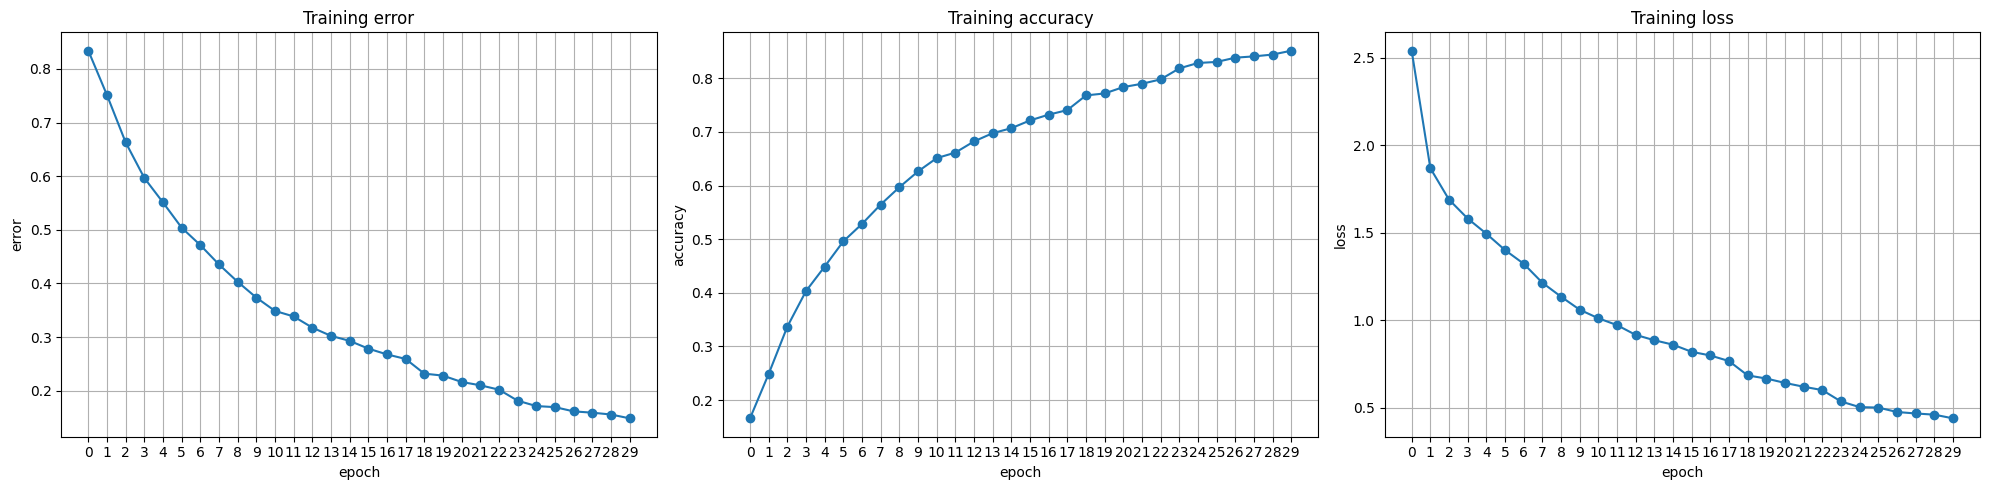

In [10]:
_, plots = plt.subplots(1, 3, figsize=(20, 5))
plot_data = {"error": error_stat, "accuracy": accuracy_stat, "loss": loss_stat}
for i, (metric, stat) in enumerate(plot_data.items()):
    x = [i for i in range(NUM_EPOCHS)]
    plots[i].plot(x, stat, marker="o")
    plots[i].set_title(f"Training {metric}")
    plots[i].set_xlabel("epoch")
    plots[i].set_xticks(x)
    plots[i].set_ylabel(metric)
    plots[i].grid()
plt.tight_layout()
plt.show()